## Packages

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import find_peaks

In [2]:
 # Ensure project root (with src/) is on sys.path so imports like `from src...` work in notebooks
import sys
from pathlib import Path
p = Path.cwd()
for _ in range(6):
    if (p / 'pyproject.toml').exists():
        project_root = p
        break
    if p.parent == p:
        project_root = Path.cwd()
        break
    p = p.parent
else:
    project_root = Path.cwd()
# Insert at front so local src/ takes precedence
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
print(f'Added project root to sys.path: {project_root}')

Added project root to sys.path: c:\Users\jarno\Downloads\stock-predictor-1


## Input Parameters

In [3]:
ticker = "HIMS"
start_date = "2019-01-01"
rsi_period = 14
periods = [20, 50, 200]
start_plot_date = "2025-01-01"
df = yf.download(ticker, start=start_date, interval="1d")
close_df = df[['Close']].copy()

C:\Users\jarno\AppData\Local\Temp\ipykernel_348\2350331122.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, interval="1d")
[*********************100%***********************]  1 of 1 completed


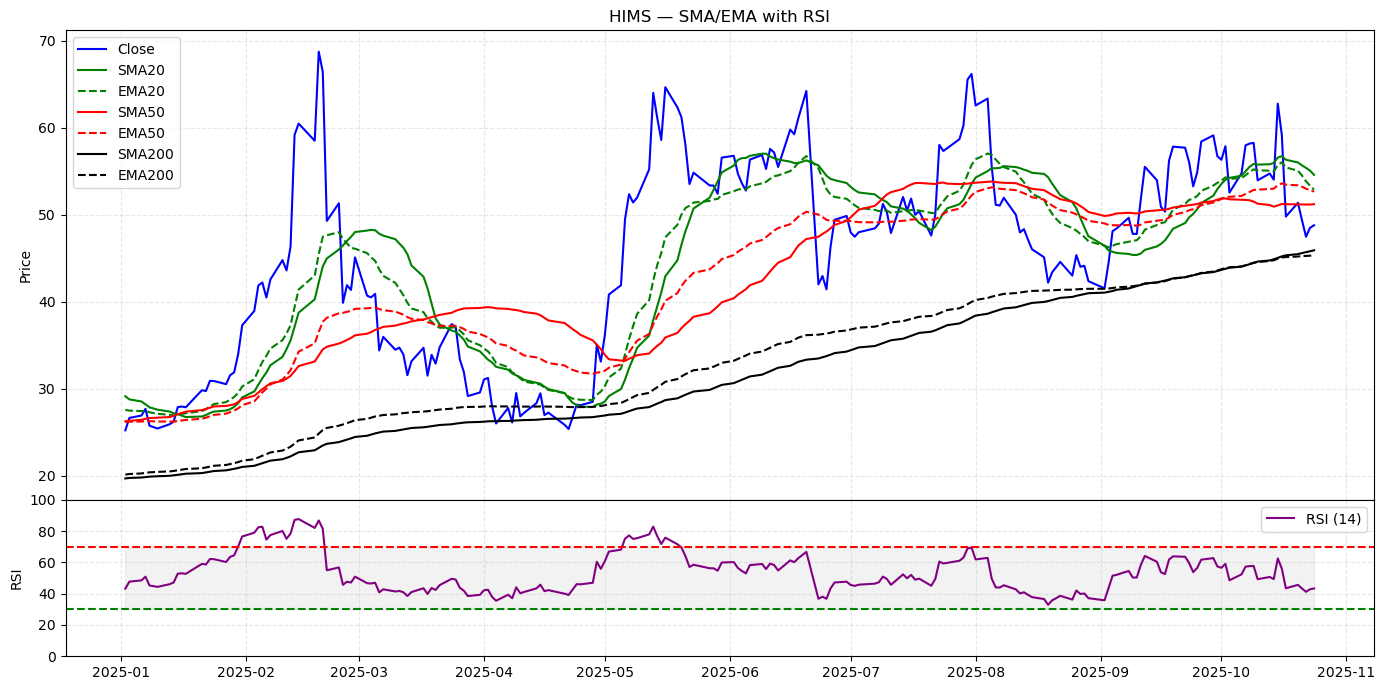

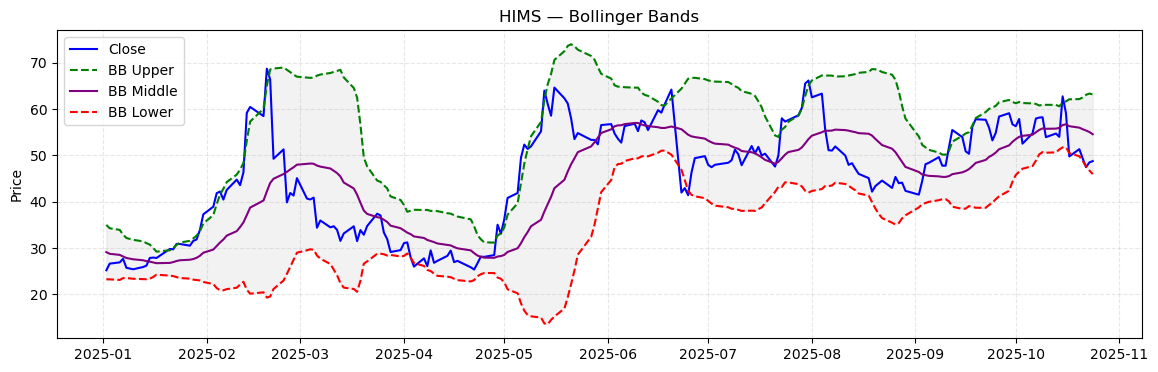

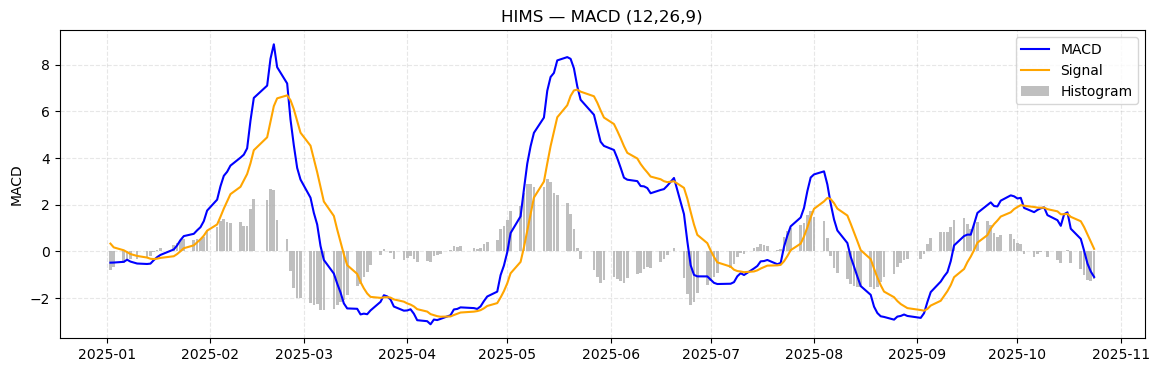

In [4]:
from src.calc_indicators import calc_sma_ema, calc_rsi, calc_macd
from src.plot_indicators import plot_sma_ema_with_rsi, plot_bollinger_bands, plot_rsi, plot_macd, plot_full_chart

plot_sma_ema_with_rsi(df, ticker, start_plot_date=start_plot_date)
plot_bollinger_bands(df, ticker, start_plot_date=start_plot_date)
plot_macd(df, ticker, start_plot_date=start_plot_date)

## SMA, EMA, BB printing

In [5]:
from src.technische_indicatoren import technische_indicatoren
technische_indicatoren(close_df, periods)

Laatste waarden voor alle indicatoren (datum: 2025-10-24):
- SMA20: 54.58
- EMA20: 52.89
- SMA50: 51.20
- EMA50: 52.65
- SMA200: 45.90
- EMA200: 45.32
- BB_Upper: 63.18
- BB_Middle: 54.58
- BB_Lower: 45.97


## Summary output Technical analysis

In [6]:
from src.summary_analysis import summary_technical_indicators
summary_technical_indicators(ticker, df, rsi_period, periods, start_plot_date);

Analyse voor **HIMS** (laatste datum: 2025-10-24):
- RSI (14): 43.32 → **Neutraal**
- Bollinger Bands: **Dicht bij onderste band (bearish trend)**
- MACD (12,26,9): **Bearish (MACD onder signaallijn, verkoopsignaal)**
- SMA/EMA (20, 50, 200): **Neutraal (koers tussen SMA/EMA)**



c:\Users\jarno\Downloads\stock-predictor-1\src\plot_indicators.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


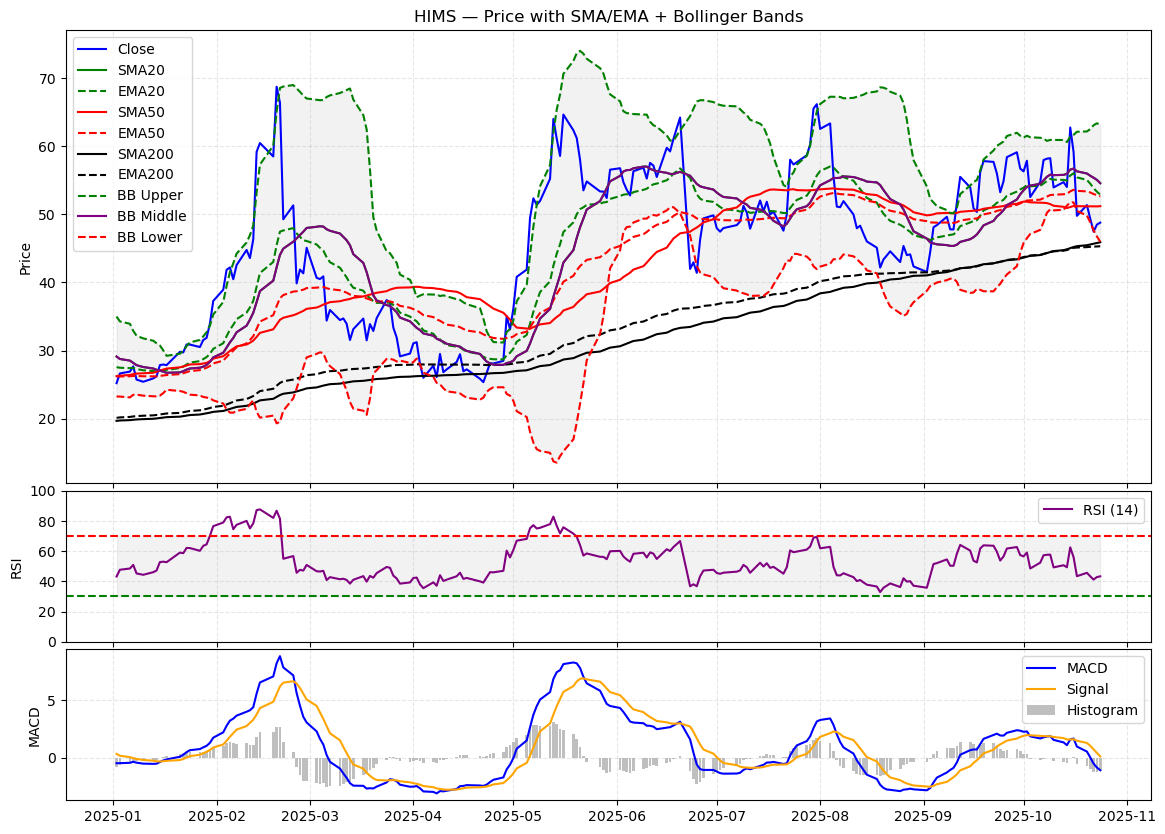

Plotted HIMS with indicators: SMA: [20, 50, 200], EMA: [20, 50, 200], Bollinger Bands: period=20, std=2, RSI: period=14, MACD: fast=12, slow=26, signal=9


In [7]:
plot_full_chart(df, ticker, [20, 50, 200], start_plot_date, sma=True, ema=True);

# Fugro:
- Sell order: EMA50, RSI +- 60.

## RSI predictor plot

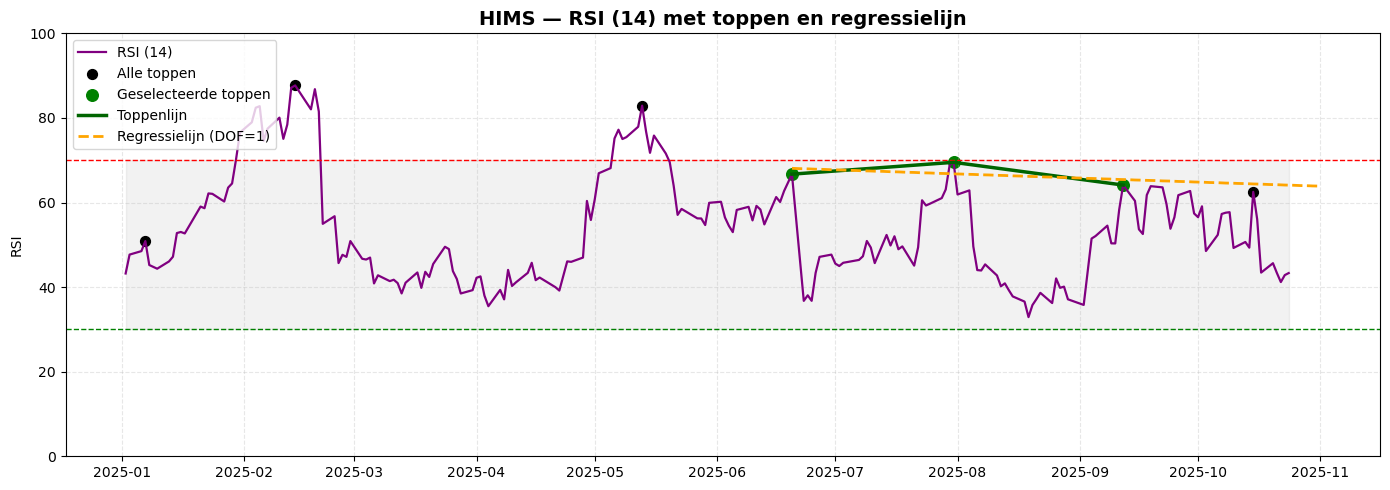

In [8]:
from src.RSI_predictor import plot_rsi_peaks
plot_rsi_peaks(df, rsi_period, start_plot_date, ticker, 
                                   dof=1, future_days=50, selected_peak_indices= [3,4,5])

## TRYOUT

In [9]:
def plot_parabolic_fit(ticker, start="2023-01-01",
                       degree=2,
                       show_tops=True,
                       show_bottoms=True,
                       interval="1d"):
    """
    Plot een aandeel met optionele parabolische fit door toppen en/of dalen.
    - degree: graad van de parabool (2 = klassiek, 3 = cubic, ...)
    - show_tops / show_bottoms: True/False om ze aan/uit te zetten
    """

    # ---------- 1. Data ophalen ----------
    df = yf.download(ticker, start=start, interval=interval)
    if df.empty:
        print(f"Geen data voor {ticker}")
        return
    df = df[['Close']].copy()

    # ---------- 2. Lokale toppen en dalen vinden ----------
    order = 5  # hoe breed het venster is voor piekdetectie (5 = mild)
    df['max'] = df.iloc[argrelextrema(df['Close'].values, np.greater_equal, order=order)[0]]['Close']
    df['min'] = df.iloc[argrelextrema(df['Close'].values, np.less_equal, order=order)[0]]['Close']

    x = np.arange(len(df))

    # ---------- 3. Plot basisprijs ----------
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(df.index, df['Close'], color='blue', label='Close', linewidth=1.5)
    ax.set_title(f"{ticker} — Parabolische fit (graad {degree})", fontsize=14, fontweight='bold')
    ax.set_ylabel("Prijs")
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.yaxis.get_major_formatter().set_scientific(False)

    # ---------- 4. Fit door toppen ----------
    if show_tops and not df['max'].dropna().empty:
        x_tops = np.where(~np.isnan(df['max']))[0]
        y_tops = df['max'].dropna().values
        coeffs_top = np.polyfit(x_tops, y_tops, degree)
        poly_top = np.poly1d(coeffs_top)
        ax.plot(df.index, poly_top(x), color='green', linestyle='--', linewidth=1.4, label=f"Top parabool (graad {degree})")
        ax.scatter(df.index[x_tops], y_tops, color='darkgreen', s=20, alpha=0.7)

    # ---------- 5. Fit door dalen ----------
    if show_bottoms and not df['min'].dropna().empty:
        x_bottoms = np.where(~np.isnan(df['min']))[0]
        y_bottoms = df['min'].dropna().values
        coeffs_bottom = np.polyfit(x_bottoms, y_bottoms, degree)
        poly_bottom = np.poly1d(coeffs_bottom)
        ax.plot(df.index, poly_bottom(x), color='red', linestyle='--', linewidth=1.4, label=f"Bodem parabool (graad {degree})")
        ax.scatter(df.index[x_bottoms], y_bottoms, color='darkred', s=20, alpha=0.7)

    ax.legend(loc='upper left', fontsize=9)
    plt.tight_layout(pad=1)
    plt.show()


# Standaard, beide parabolen, kwadratisch
plot_parabolic_fit("HIMS", degree=2)

# Alleen toppen, cubic parabool
# plot_parabolic_fit("AAPL", degree=3, show_bottoms=False)

# # Alleen bodems, startend vanaf 2022
# plot_parabolic_fit("AAPL", start="2022-01-01", degree=2, show_tops=False)



C:\Users\jarno\AppData\Local\Temp\ipykernel_348\484591232.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, interval=interval)
[*********************100%***********************]  1 of 1 completed


NameError: name 'argrelextrema' is not defined